In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.api import VAR, DynamicVAR, VARMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyramid.arima import auto_arima
import pytemperature
from itertools import product

### Importing base data
- Change nights index to frequency 'MS' (Month start)
- Convert all temperatures from Celsius to Kelvin to avoid negative values (not accepted in VAR)

In [2]:
nights = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/nights_2010-2017.csv', index_col='date', parse_dates=['date'], 
                          usecols=[*range(1, 15)])
nights.index.freq = 'MS'
temp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/avgtemp_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
temp = pytemperature.c2k(temp)
daysoff = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/daysoff_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=['date','daysoff'])
gdp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/regionalGDP_2010-2015.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])

### Corrected Seasonal MASE function
- Finally correct this time!! 3rd time's a charm... 
- Problem with previous Seasonal MASE was that we never used Seaonality=12 argument with proper inputs; the adjusted function below is easier to use and gives accurate results

In [3]:
def seasonal_MASE(last_season, this_season, forecast):
    '''
    Parameters
    ----------
    last_season: array containing data for last season (size S)
    
    current_truth: array containing data for current season (size S)
    
    forecast: array containing data predictiing current season (size S)
    '''
    forecast_errors = np.abs(this_season - forecast)
    #print(forecast_errors)
    mean_absolute_forecast_error = np.average(forecast_errors)
    #print('forecast MAE', mean_absolute_forecast_error)
    
    naive = last_season
    naive.index = this_season.index
    naive_errors = np.abs(this_season - naive)
    #print(naive_errors)
    mean_absolute_naive_error = np.average(naive_errors)
    #print('naive MAE', mean_absolute_naive_error)
    
    return mean_absolute_forecast_error / mean_absolute_naive_error

### Big CrossVal loop
- Puts results in a dataframe with error measures (MAE, RMSE, max error, seasonal MASE) for following parameters: Regions, with/without GDP, trend model (Holt or Seasonal ARIMA), number of lags
- Make sure to change the 'region' values in the args dictionary; the rest runs all by itself
- **Attention when generating results for more than 1 region**: it may take from 10 minutes to _2 hours_ (for 5 regions) to run

In [4]:
args = {
    'region': ['CVL', 'IDF', 'NAQ', 'ARA', 'PAC'],
    'with_gdp': [False, True],
    'trend_model': ['Holt', 'ARIMA'],
    'lag': range(1,6),
    # periods is a tuple of (training start year, training end year, test year)
    'periods': [('2010-01-01', f'{end_year}-01-01', f'{end_year + 1}-01-01')
                 for end_year in range(2012, 2017)]
}

error_df = pd.DataFrame(columns=list(args.keys()) + ['MAE', 'RMSE', 'Max_error', 'MASE'])

for region, with_gdp, trend_model, lag, periods in product(*args.values()):
    start_year, end_year, predict_year = periods
    input_data = pd.concat([nights, temp, daysoff, gdp], axis=1).dropna()
    input_data = input_data[[f'nights_{region}',
                             f'avgtemp_{region}',
                             f'gdp_{region}',
                             'daysoff']]
    target = nights[[f'nights_{region}']]

    training_period = (input_data.index>=start_year)&(input_data.index<end_year) 
    testing_period = (target.index>=end_year)&(target.index<predict_year)

    train_data = input_data[training_period]
    test_data = np.array(target[testing_period])

    if not with_gdp:
        train_data.drop(f'gdp_{region}', axis=1)

    # --------Seasonal decompose----------
    decomposed_data = seasonal_decompose(
        train_data, model='multiplicative', extrapolate_trend='freq')  
    seasonal_data, trend_data, residual_data = (decomposed_data.seasonal,
                                                decomposed_data.trend, decomposed_data.resid)

    # ---------Seasonal prediction (Same as last year of training data)---------
    seasonal_train = seasonal_data[
        (seasonal_data.index>=start_year)&(seasonal_data.index<end_year)]
    seasonal_forecast = pd.DataFrame(seasonal_train[f'nights_{region}'].values[-12:])

    # --------Trend prediction (Linear Holt)----------
    if trend_model == 'Holt':
        trend = Holt(trend_data[f'nights_{region}']).fit(optimized=True)
        trend_forecast = pd.DataFrame(trend.predict(start=0, end=11).values)

    elif trend_model == 'ARIMA':
        trend = auto_arima(trend_data[f'nights_{region}'], 
                     start_p=0, start_q=0, max_p=20, max_q=20, m=12, 
                     start_P=0, max_P=20, seasonal=True, max_d=2, max_D=2, 
                     trace=False, error_action='ignore', suppress_warnings=True, 
                     stepwise=True, random=True, random_state=42) 
        trend_forecast = pd.DataFrame(trend.predict(n_periods=12))

    # --------Residual prediction (VAR)----------
    resid_model = VAR(residual_data, dates=residual_data.index)    
    resid_results = resid_model.fit(lag)
    lag_order = resid_results.k_ar
    resid_forecast = pd.DataFrame(
        resid_results.forecast(residual_data.values[-lag_order:], 12))

    # --------Recomposing results----------
    forecast = seasonal_forecast[0] * trend_forecast[0] * resid_forecast[0]

    # --------Calculated error measures for each CV step----------
    rmse_test = np.sqrt(mean_squared_error(test_data, forecast))
    mae_test = mean_absolute_error(test_data, forecast)
    years_train_data = len(train_data.index.strftime('%Y').unique().tolist())

    test = pd.Series(test_data[:,0],
                     index=target[f'nights_{region}'][testing_period].index)
    forecast.index = target[f'nights_{region}'][testing_period].index
    
    mase = seasonal_MASE(target[str(int(end_year[:4]) - 1)], target[end_year[:4]], forecast[0])
    max_error = np.max(np.abs(forecast - test)) / test[forecast.idxmax(
        np.abs(forecast - test))]
    new_row = {
        'region': region,
        'lag': lag,
        'periods': years_train_data,
        'trend_model': trend_model, 
        'with_gdp': with_gdp,
        'MAE': mae_test,
        'RMSE': rmse_test,
        'Max_error': max_error,
        'MASE': mase,
    }
    error_df = error_df.append(new_row, ignore_index=True)


### Generated dataframe with error measures for each parameter/region

In [5]:
error_df.tail(5)

,region,with_gdp,trend_model,lag,periods,MAE,RMSE,Max_error,MASE
495,PAC,True,ARIMA,5,2,86.755830,104.783108,0.058146,18.330278
496,PAC,True,ARIMA,5,3,79.107771,103.554404,0.066301,13.529698
497,PAC,True,ARIMA,5,4,68.434186,86.052697,0.059828,10.608926
498,PAC,True,ARIMA,5,5,95.548756,113.390464,0.053451,17.503811
499,PAC,True,ARIMA,5,6,84.299234,111.037124,0.087717,9.062827


### Lowest MASE by region and their respective settings
- NO VAR models were better than the seasonal naive model!!!

In [6]:
for reg, group in error_df.groupby('region'):
    print(group.loc[group.MASE.idxmin()])

region              ARA
with_gdp          False
trend_model        Holt
lag                   3
periods               4
MAE             75.5778
RMSE            100.842
Max_error      0.095736
MASE            2.69956
Name: 312, dtype: object
region               CVL
with_gdp           False
trend_model        ARIMA
lag                    3
periods                3
MAE              17.9766
RMSE             25.4392
Max_error      0.0806557
MASE             7.83889
Name: 36, dtype: object
region              IDF
with_gdp          False
trend_model       ARIMA
lag                   4
periods               6
MAE             586.054
RMSE            656.701
Max_error      0.195068
MASE            1.28227
Name: 144, dtype: object
region               NAQ
with_gdp           False
trend_model        ARIMA
lag                    1
periods                5
MAE              107.203
RMSE             121.506
Max_error      0.0886124
MASE             10.5345
Name: 228, dtype: object
region             

### Lowest MASE out of all regions
- Still worse than seasonal naive

In [7]:
error_df.loc[error_df.MASE.idxmin()]

region              IDF
with_gdp          False
trend_model       ARIMA
lag                   4
periods               6
MAE             586.054
RMSE            656.701
Max_error      0.195068
MASE            1.28227
Name: 144, dtype: object

### Highest MASE out of all regions

In [8]:
error_df.loc[error_df.MASE.idxmax()]

region              IDF
with_gdp          False
trend_model        Holt
lag                   2
periods               2
MAE             184.671
RMSE            222.774
Max_error      0.070175
MASE            26.2198
Name: 105, dtype: object

### With or without GDP for each region
- x = Number of training data periods (years)
- y = RMSE
- Both Holt and ARIMA trend models are plotted on the same graph
- Important part is to see if RMSE has changed by including/excluding GDP
- Looking at the results, GDP has very little impact on the model: It can be removed

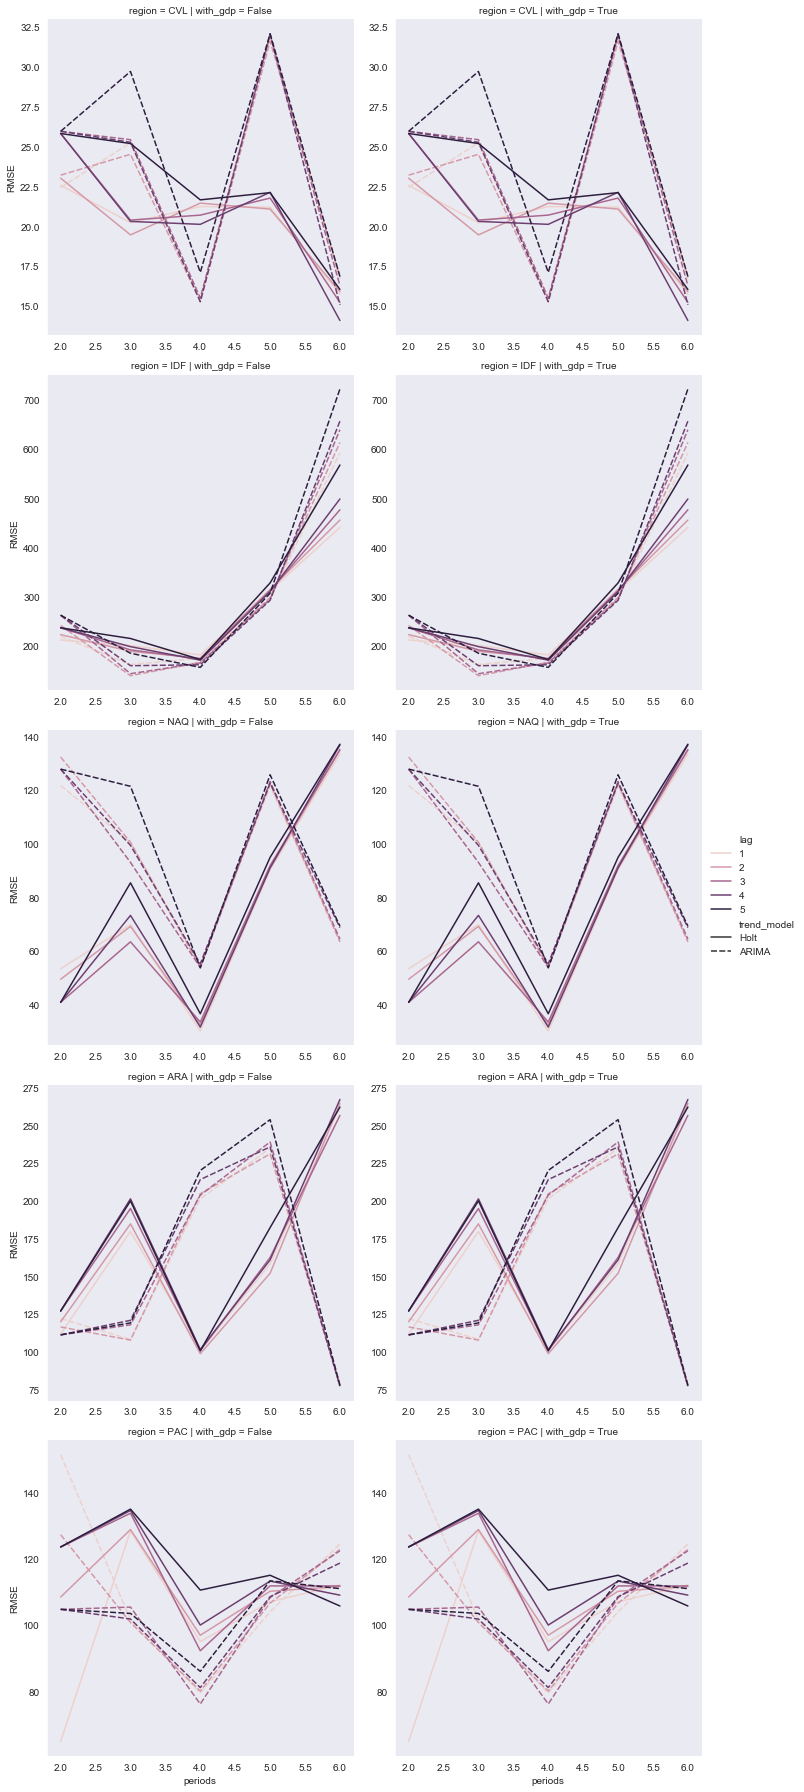

In [9]:
sns.set_style("dark")
error_df.lag = error_df.lag.astype('int')

gdp_plots = sns.relplot(x='periods', y='RMSE',
            hue='lag', style='trend_model',
            row='region',
            col='with_gdp',
            kind='line', legend='full',
            data=error_df,
            facet_kws={'sharex': False, 'sharey': False})


### Holt vs. Seasonal ARIMA for Trend
**Attention**: y axis scales are *not* the same for each graph
- CVL: More stable performance with Holt
- IDF: Bad with either model
- NAQ: Bad with either model
- ARA: Less bad with Seasonal ARIMA
- PAC: More stable performance with Holt

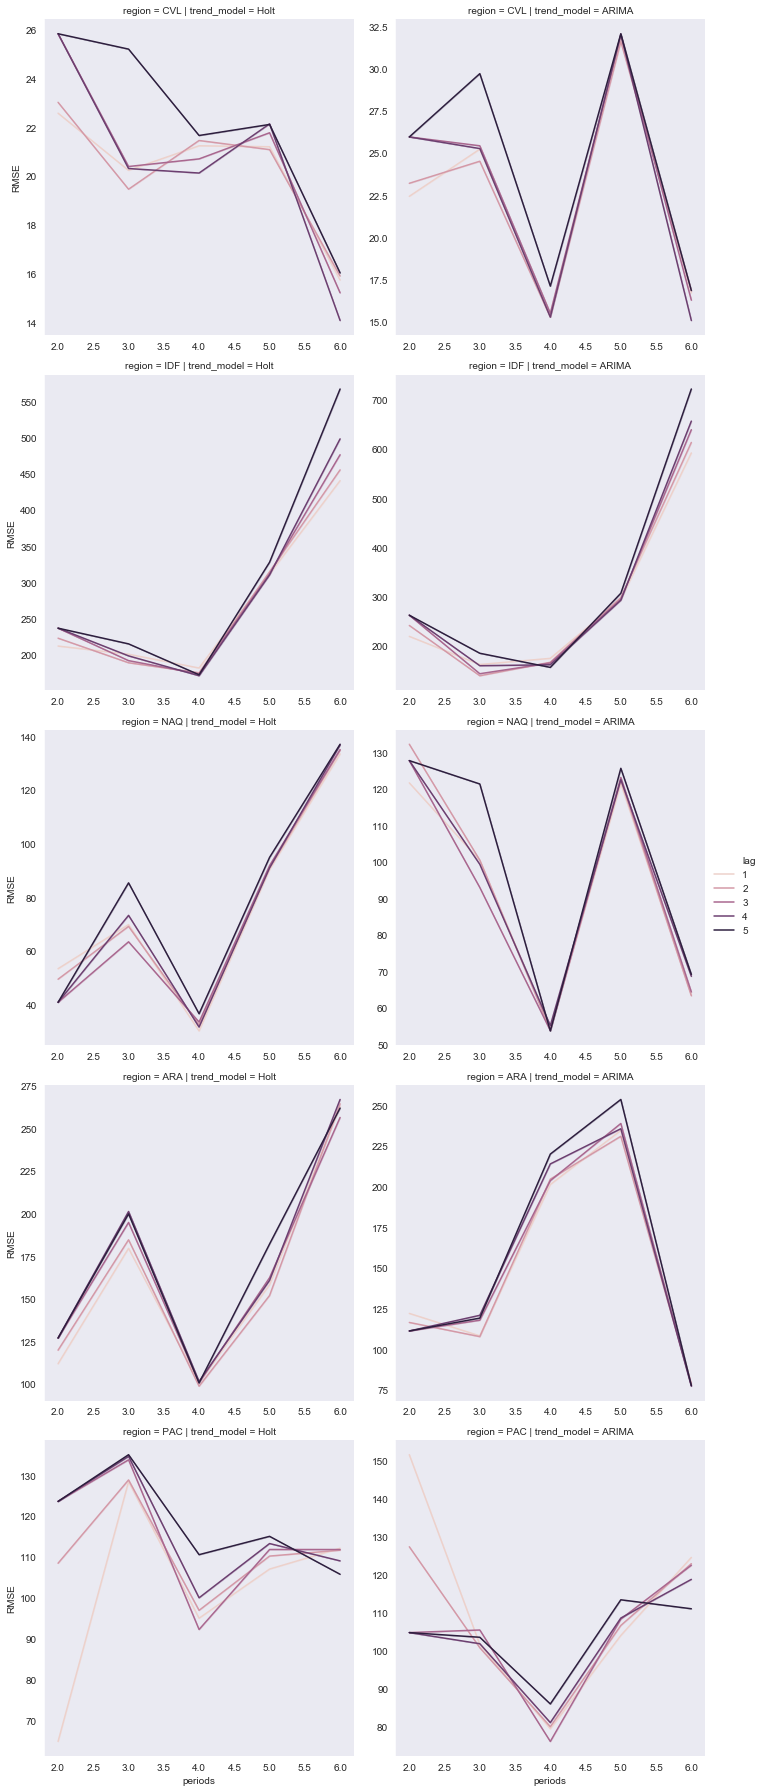

In [10]:
g = sns.relplot(x='periods', y='RMSE',
            hue='lag', 
            row='region', col='trend_model',
            kind='line', legend='full',
            data=error_df,
            facet_kws={'sharex': False, 'sharey': False})

### MASE for each region 
- With parameters chosen after deciding above (GDP, trend_model...)

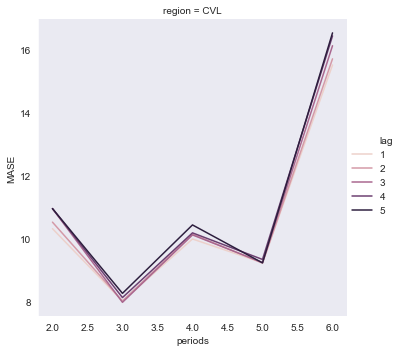

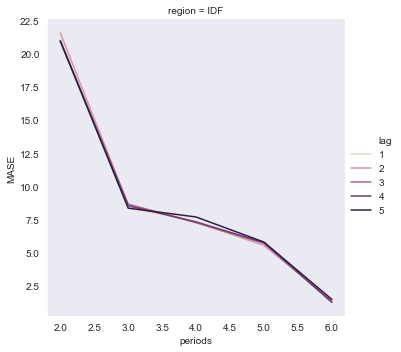

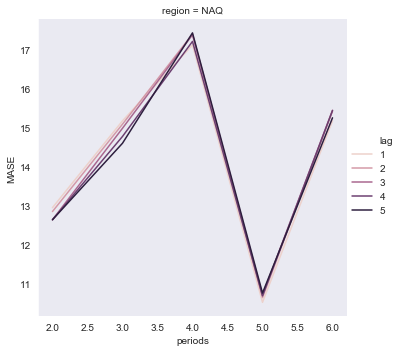

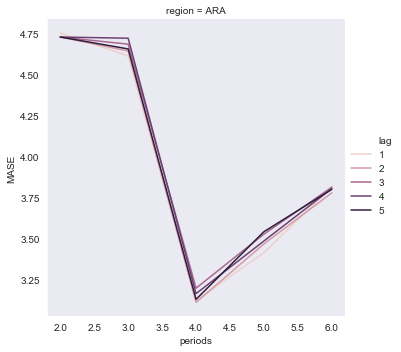

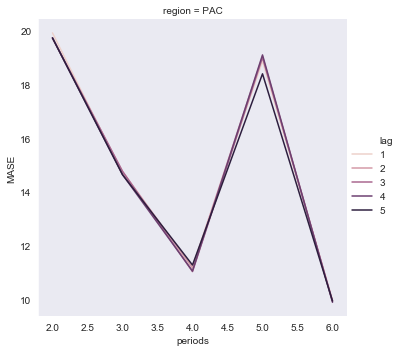

In [11]:
sns.relplot(x='periods', y='MASE',
            hue='lag', 
            row='region',
            kind='line', legend='full',
            data=error_df.query("region == 'CVL' and with_gdp == False and trend_model == 'Holt'"))

sns.relplot(x='periods', y='MASE',
            hue='lag', 
            row='region',
            kind='line', legend='full',
            data=error_df.query("region == 'IDF' and with_gdp == False and trend_model == 'ARIMA'"))

sns.relplot(x='periods', y='MASE',
            hue='lag', 
            row='region',
            kind='line', legend='full',
            data=error_df.query("region == 'NAQ' and with_gdp == False and trend_model == 'ARIMA'"))

sns.relplot(x='periods', y='MASE',
            hue='lag', 
            row='region',
            kind='line', legend='full',
            data=error_df.query("region == 'ARA' and with_gdp == False and trend_model == 'ARIMA'"))

sns.relplot(x='periods', y='MASE',
            hue='lag', 
            row='region',
            kind='line', legend='full',
            data=error_df.query("region == 'PAC' and with_gdp == False and trend_model == 'Holt'"))

### RMSE for each lag for each region
- Choose number of lags that give the most stable performance (smoothest curve)
- Ideal: decreasing RMSE as there is more training data

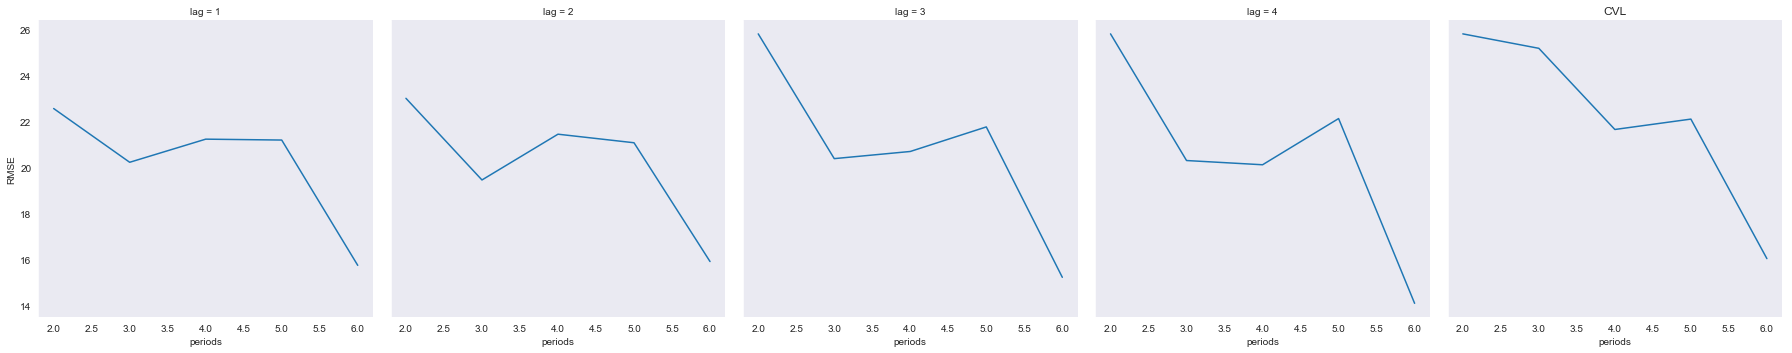

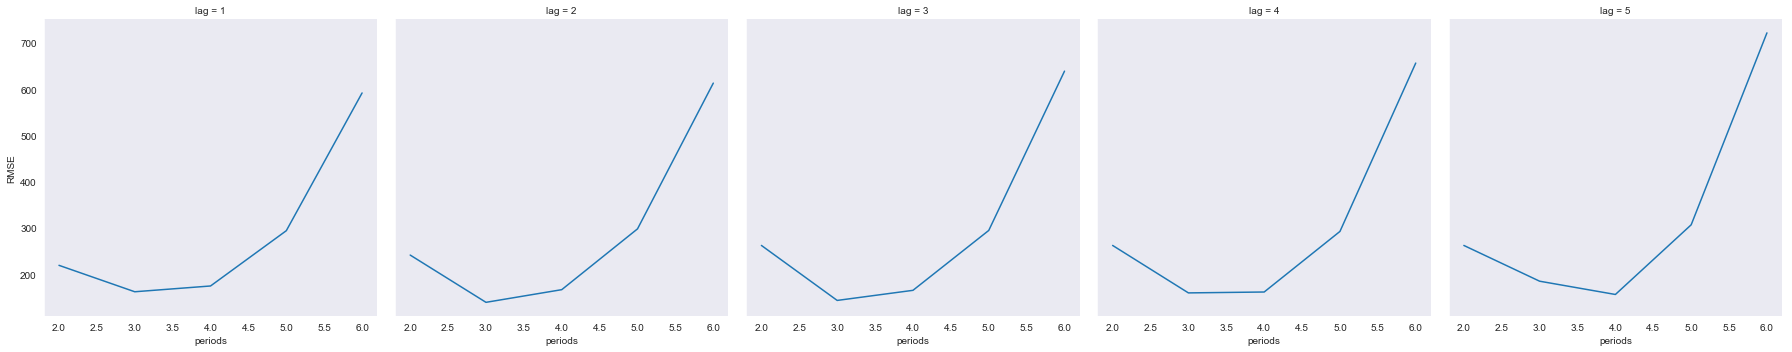

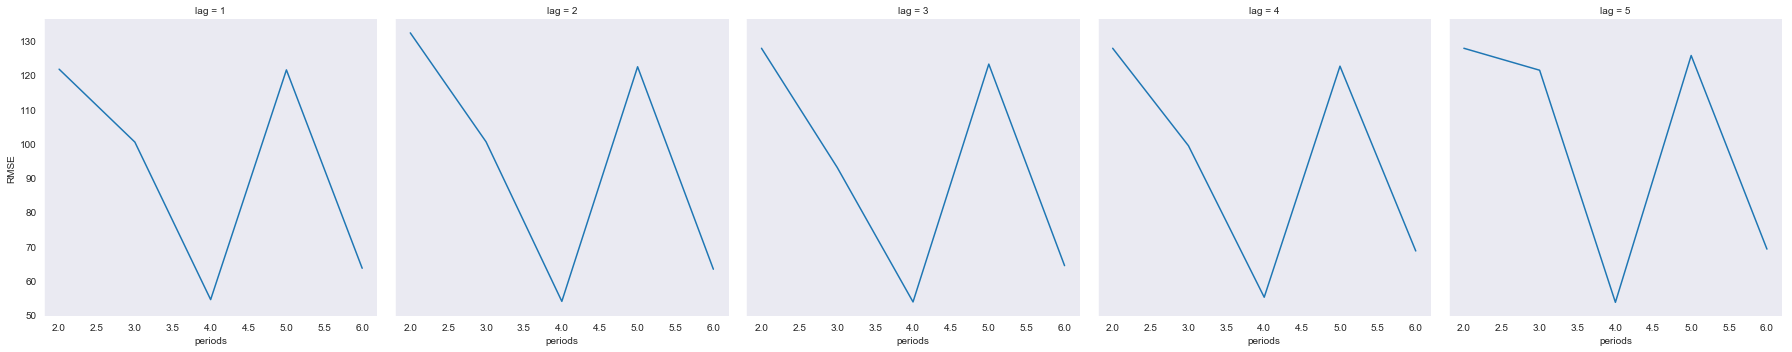

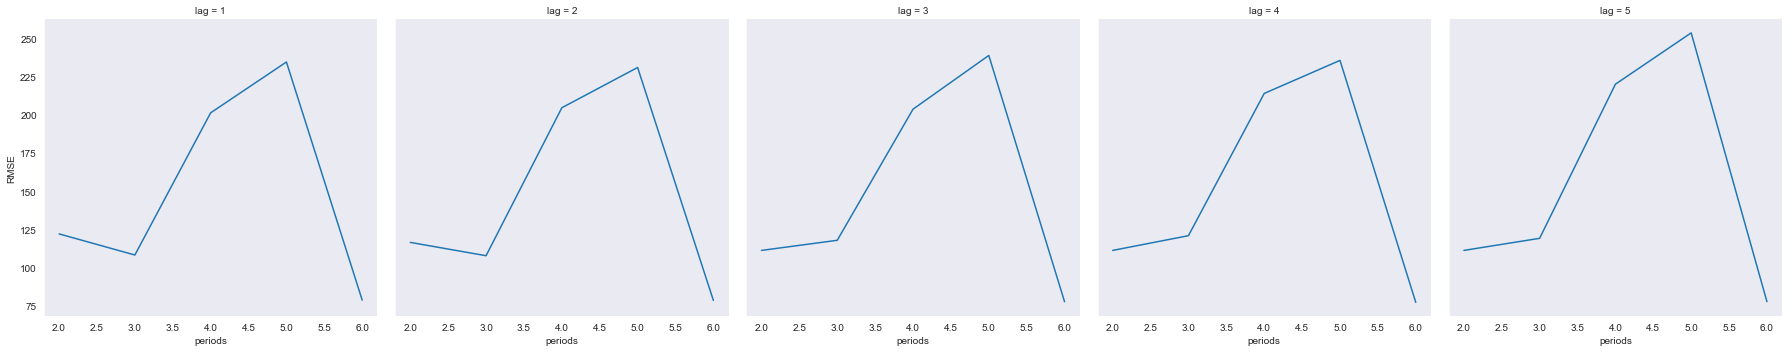

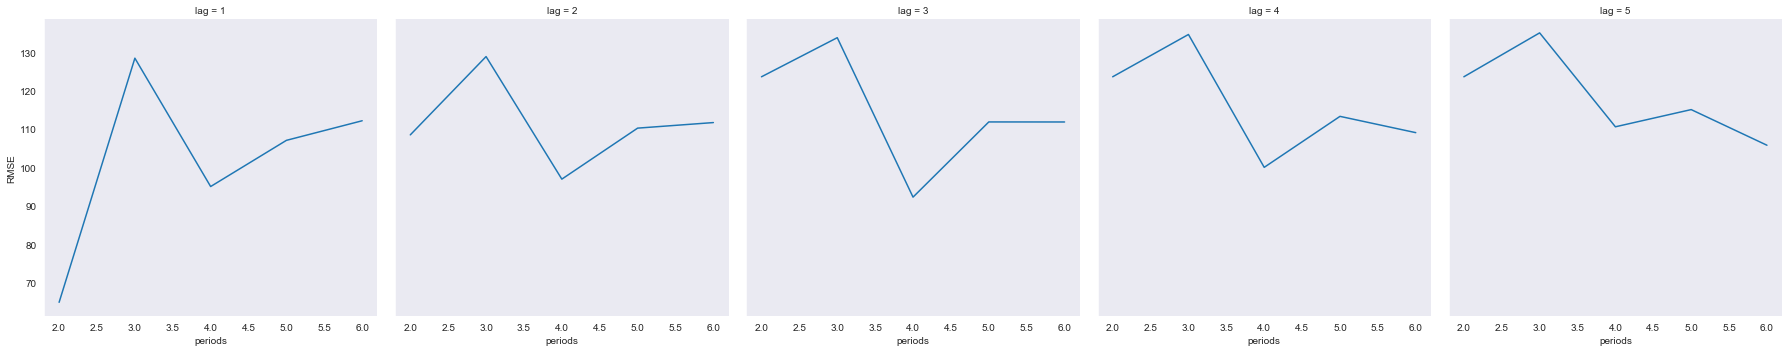

In [25]:
sns.relplot(x='periods', y='RMSE',
            col='lag', 
            kind='line', legend='full',
            data=error_df.query("region == 'CVL' and with_gdp == False and trend_model == 'Holt'"))

sns.relplot(x='periods', y='RMSE',
            col='lag',
            kind='line', legend='full',
            data=error_df.query("region == 'IDF' and with_gdp == False and trend_model == 'ARIMA'"))

sns.relplot(x='periods', y='RMSE',
            col='lag',
            kind='line', legend='full',
            data=error_df.query("region == 'NAQ' and with_gdp == False and trend_model == 'ARIMA'"))

sns.relplot(x='periods', y='RMSE',
            col='lag',
            kind='line', legend='full',
            data=error_df.query("region == 'ARA' and with_gdp == False and trend_model == 'ARIMA'"))

sns.relplot(x='periods', y='RMSE',
            col='lag',
            kind='line', legend='full',
            data=error_df.query("region == 'PAC' and with_gdp == False and trend_model == 'Holt'"))


### RMSE for region with chosen lags
- Lags chosen from comparison above

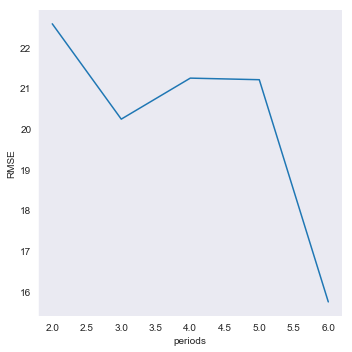

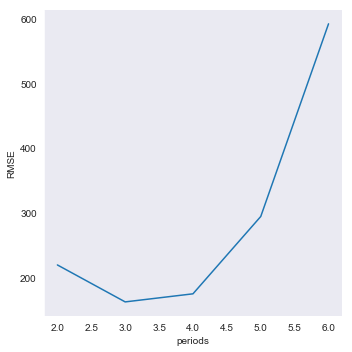

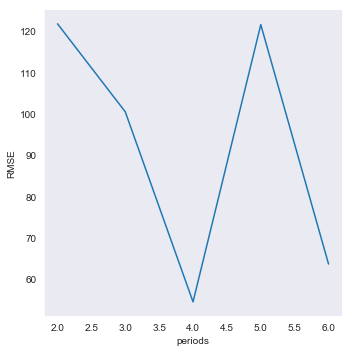

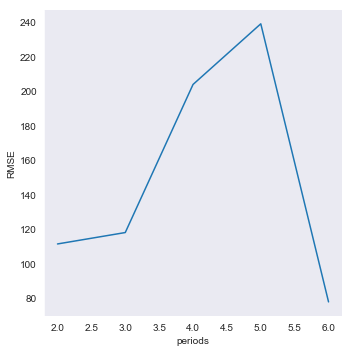

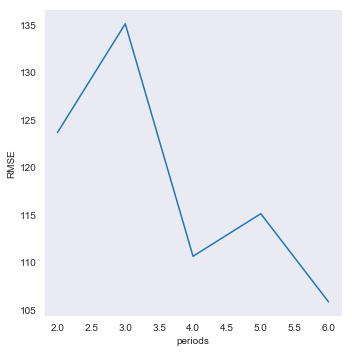

In [27]:
sns.relplot(x='periods', y='RMSE',
            kind='line', legend='full',
            data=error_df.query("region == 'CVL' and with_gdp == False and trend_model == 'Holt' and lag == 1"))

sns.relplot(x='periods', y='RMSE',
            kind='line', legend='full',
            data=error_df.query("region == 'IDF' and with_gdp == False and trend_model == 'ARIMA' and lag == 1"))

sns.relplot(x='periods', y='RMSE',
            kind='line', legend='full',
            data=error_df.query("region == 'NAQ' and with_gdp == False and trend_model == 'ARIMA' and lag == 1"))

sns.relplot(x='periods', y='RMSE',
            kind='line', legend='full',
            data=error_df.query("region == 'ARA' and with_gdp == False and trend_model == 'ARIMA' and lag == 3"))

sns.relplot(x='periods', y='RMSE',
            kind='line', legend='full',
            data=error_df.query("region == 'PAC' and with_gdp == False and trend_model == 'Holt' and lag == 5"))


### Average error measures for the chosen model
- After deciding on with/without GDP, trend model, and number of lags above

In [30]:
print('Average error and MASE for CVL, no GDP, Holt, lag=1')
print(error_df[(error_df.region=='CVL')&(error_df.with_gdp==False)&(error_df.trend_model=='Holt')&(error_df.lag==1)].mean())
print('----')

print('Average error and MASE for IDF, no GDP, ARIMA, lag=1')
print(error_df[(error_df.region=='IDF')&(error_df.with_gdp==False)&(error_df.trend_model=='ARIMA')&(error_df.lag==1)].mean())
print('----')

print('Average error and MASE for NAQ, no GDP, ARIMA, lag=1')
print(error_df[(error_df.region=='NAQ')&(error_df.with_gdp==False)&(error_df.trend_model=='ARIMA')&(error_df.lag==1)].mean())
print('----')

print('Average error and MASE for ARA, no GDP, ARIMA, lag=3')
print(error_df[(error_df.region=='NAQ')&(error_df.with_gdp==False)&(error_df.trend_model=='ARIMA')&(error_df.lag==3)].mean())
print('----')

print('Average error and MASE for PAC, no GDP, Holt, lag=5')
print(error_df[(error_df.region=='PAC')&(error_df.with_gdp==False)&(error_df.trend_model=='Holt')&(error_df.lag==5)].mean())
print('----')

Average error and MASE for CVL, no GDP, Holt, lag=1
lag           1.000000
MAE          16.842473
RMSE         20.198933
Max_error     0.055650
MASE         10.610397
dtype: float64
----
Average error and MASE for IDF, no GDP, ARIMA, lag=1
lag            1.000000
MAE          241.650204
RMSE         288.402114
Max_error      0.085407
MASE           8.818227
dtype: float64
----
Average error and MASE for NAQ, no GDP, ARIMA, lag=1
lag           1.000000
MAE          79.209024
RMSE         92.335296
Max_error     0.071526
MASE         14.191997
dtype: float64
----
Average error and MASE for ARA, no GDP, ARIMA, lag=3
lag           3.000000
MAE          79.804392
RMSE         92.428729
Max_error     0.071898
MASE         14.235839
dtype: float64
----
Average error and MASE for PAC, no GDP, Holt, lag=5
lag            5.000000
MAE           99.178008
RMSE         118.022189
Max_error      0.069181
MASE          14.802160
dtype: float64
----


### Next steps:
- Plotting more graphs and analyzing them (ex. seasonal MASE graphs to compare forecast with seasonal naive)
- Compare best VAR model with best SARIMAX and Prophet models for each region
- See if any models are better than naive seasonal!

### Finished:
- Choosing best lags for each model per region